In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
markers = {'triangle':['^', sns.color_palette()[0]], 
           'square':['s', sns.color_palette()[1]],
           'circle':['o', sns.color_palette()[2]]}

def plot_binary(data, label):
    data_copy = data.copy()
    data_copy['$y$ == ' + label] = (data_copy['$y$'] == label).astype('category')
    
    sns.lmplot('$x_1$', '$x_2$', data=data_copy, hue='$y$ == ' + label, hue_order=[True, False], 
               markers=[markers[label][0], 'x'], palette=[markers[label][1], 'gray'],
               fit_reg=False)
    plt.xlim(1.0, 4.0)
    plt.ylim(1.0, 4.0);

In [3]:
# HIDDEN
def plot_confusion_matrix(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap=matplotlib.cm.get_cmap('gist_yarg'))
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.xticks([0.5, 1.5, 2.5], ['iris-setosa', 'iris-versicolor', 'iris-virginica'])
    plt.yticks([0.5, 1.5, 2.5], ['iris-setosa', 'iris-versicolor', 'iris-virginica'], rotation='horizontal')
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

## Multiclass Classification

Our classifiers thus far perform binary classification where each observation belongs to one of two classes; we classified emails as either ham or spam, for example. However, many data science problems involve **multiclass classification**, in which we would like to classify observations as one of several different classes. For example, we may be interested in classifying emails into folders such as Family, Friends, Work, and Promotions. To solve these types of problems, we use a new method called **one-vs-rest (OvR) classification**.

### One-Vs-Rest Classification

In OvR classification (also known as one-vs-all, or OvA), we decompose a multiclass classification problem into several different binary classification problems. For example, we might observe training data as shown below:

In [4]:
# HIDDEN
shapes = pd.DataFrame(
    [[1.3, 3.6, 'triangle'], [1.6, 3.2, 'triangle'], [1.8, 3.8, 'triangle'],
     [2.0, 1.2, 'square'], [2.2, 1.9, 'square'], [2.6, 1.4, 'square'],
     [3.2, 2.9, 'circle'], [3.5, 2.2, 'circle'], [3.9, 2.5, 'circle']],
    columns=['$x_1$', '$x_2$', '$y$']
)

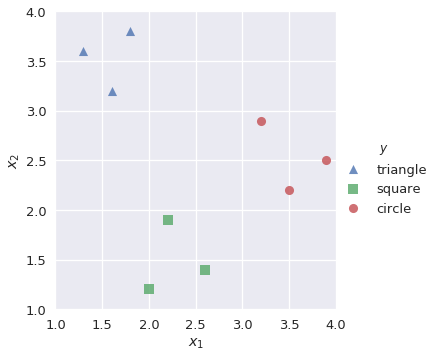

In [5]:
# HIDDEN
sns.lmplot('$x_1$', '$x_2$', data=shapes, hue='$y$', markers=['^', 's', 'o'], fit_reg=False)
plt.xlim(1.0, 4.0)
plt.ylim(1.0, 4.0);

Our goal is to build a multiclass classifier that labels observations as `triangle`, `square`, or `circle` given values for $x_1$ and $x_2$. First, we want to build a binary classifier `lr_triangle` that predicts observations as `triangle` or not `triangle`:

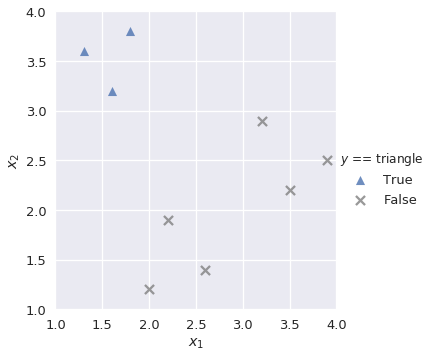

In [6]:
plot_binary(shapes, 'triangle')

Similarly, we build binary classifiers `lr_square` and `lr_circle` for the remaining classes:

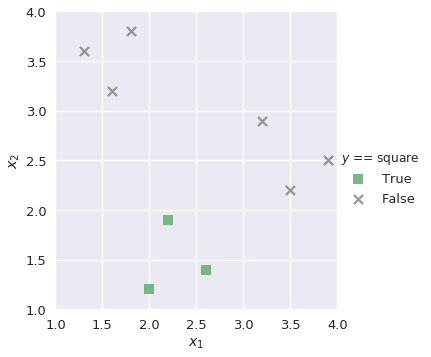

In [7]:
plot_binary(shapes, 'square')

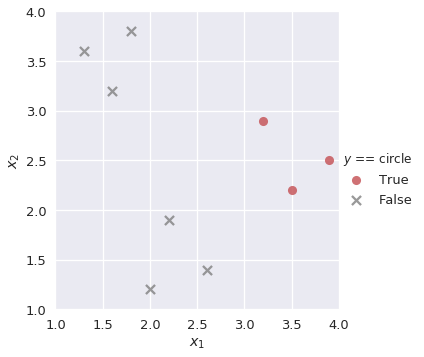

In [8]:
plot_binary(shapes, 'circle')

We know that the output of the sigmoid function in logistic regression is a probability value from 0 to 1. To solve our multiclass classification task, we find the probability of the positive class in each binary classifier and select the class that outputs the highest positive class probability. For example, if we have a new observation with the following values:

$x_1$ | $x_2$
---   | ---
3.2   | 2.5

Then our multiclass classifier would input these values to each of `lr_triangle`, `lr_square`, and `lr_circle`. We extract the positive class probability of each of the three classifiers:

In [9]:
# HIDDEN
lr_triangle = LogisticRegression(random_state=42)
lr_triangle.fit(shapes[['$x_1$', '$x_2$']], shapes['$y$'] == 'triangle')
proba_triangle = lr_triangle.predict_proba([[3.2, 2.5]])[0][1]

lr_square = LogisticRegression(random_state=42)
lr_square.fit(shapes[['$x_1$', '$x_2$']], shapes['$y$'] == 'square')
proba_square = lr_square.predict_proba([[3.2, 2.5]])[0][1]

lr_circle = LogisticRegression(random_state=42)
lr_circle.fit(shapes[['$x_1$', '$x_2$']], shapes['$y$'] == 'circle')
proba_circle = lr_circle.predict_proba([[3.2, 2.5]])[0][1]

`lr_triangle` | `lr_square`   | `lr_circle`
---           | ---           | ---
0.145748      |      0.285079 | 0.497612

Since the positive class probability of `lr_circle` is the greatest of the three, our multiclass classifier predicts that the observation is a circle.

## Case Study: Iris dataset

The [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) is a famous dataset that is often used in data science to explore machine learning concepts. There are three classes, each representing a type of Iris plant:
- Iris-setosa
- Iris-versicolor
- Iris-virginica

There are four features available in the dataset:
- Sepal length (cm)
- Sepal width (cm)
- Petal length (cm)
- Petal width (cm)

![](https://raw.githubusercontent.com/DS-100/textbook/master/assets/petal_sepal.png)

We will create a multiclass classifier that predicts the type of Iris plant based on the four features above. First, we read in the data:

In [10]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                  header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

iris

sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

In [11]:
X, y = iris.drop('species', axis=1), iris['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

After dividing the dataset into train and test splits, we fit a multiclass classifier to our training data. By default, scikit-learn's `LogisticRegression` sets `multi_class='ovr'`, which creates binary classifiers for each unique class:

In [12]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We predict on the test data, and use a confusion matrix to evaluate the results.

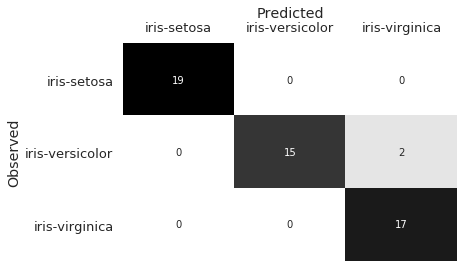

In [13]:
y_pred = lr.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

The confusion matrix shows that our classifier misclassified two `Iris-versicolor` observations as `Iris-virginica`. In observing the `sepal_length` and `sepal_width` features, we can hypothesize why this may have occurred:

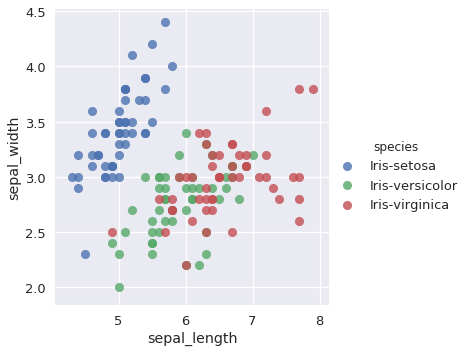

In [14]:
# HIDDEN
sns.lmplot(x='sepal_length', y='sepal_width', data=iris, hue='species', fit_reg=False);

The `Iris-versicolor` and `Iris-virginica` points overlap for these two features. Though the remaining features (`petal_width` and `petal_length`) contribute additional information to help distinguish between the two classes, our classifier still misclassified the two observations.

Likewise in the real world, misclassifications can be common if two classes bear similar features. Confusion matrices are valuable because they help us identify the errors that our classifier makes, and thus provides insight on what kind of additional features we may need to extract in order to improve the classifier.

## Multilabel Classification

Another type of classification problem is **multilabel classification**, in which each observation can have multiple labels. An example would be a document classification system: a document can have positive or negative sentiment, religious or nonreligious content, and liberal or conservative leaning. Multilabel problems can also be multiclass; we may want our document classification system to distinguish between a list of genres, or identify the language that the document is written in. 

We may perform multilabel classification by simply training a separate classifier on each set of labels. To label a new point, we combine each classifier's predictions.

## Summary

Classification problems are often complex in nature. Sometimes, the problem requires us to distinguish an observation between multiple classes; in other situations, we may need to assign several labels to each observation. We leverage our knowledge of binary classifiers to create multiclass and multilabel classification systems that can achieve these tasks.